In [1]:
# !pip install imgur-downloader
# !pip install python-magic
# !apt install libmagic-dev
# !pip install requests_toolbelt
# !pip install pytumblr
# !pip install tweepy
# !pip install pafy
# !pip install youtube-dl

In [2]:
# no web cache, file check instead

In [3]:
from pymongo import MongoClient
import json
import requests
from requests_toolbelt import SSLAdapter
import pytumblr
from pathlib import Path
import glob
from PIL import Image
from io import BytesIO
import magic
# from imgur_downloader import ImgurDownloader
from lib.libpatching.ImgurDownloader import ImgurDownloader
from collections import Counter
import tweepy
import pafy

from IPython.display import JSON

from lib.parallel import parallel

In [4]:
mongo_uri = json.load(open('./credentials/mongodb_credentials.json'))['uri']
mongo = MongoClient(mongo_uri)
db = mongo['bad-vis']
posts = db['posts']
dlthumbnailresults = db['dlthumbnailresults']
dlpreviewresults = db['dlpreviewresults']
dlexternalresults = db['dlexternalresults']
dlthumbnailaltresults = db['dlthumbnailaltresults']
dlpreviewaltresults = db['dlpreviewaltresults']
dlexternalaltresults = db['dlexternalaltresults']

In [5]:
images_dir = Path('../images')

# Example

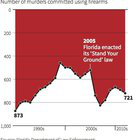

In [6]:
post = posts.find_one({'id': 'e2cvur'})
r = requests.get(post['thumbnail']['url'])
pil_image = Image.open(BytesIO(r.content))
pil_image

# Downloaders

In [7]:
def get_content_type_ext (content_type, req=None):
    if not content_type:
        content_type = ''
    content_type = content_type.lower()
    if content_type.startswith('image/jpeg') or content_type.startswith('image/jpg'):
        return '.jpg'
    elif content_type.startswith('image/png'):
        return '.png'
    elif content_type.startswith('image/gif'):
        return '.gif'
    elif content_type.startswith('image/webp'):
        return '.webp'
    elif content_type.startswith('image/svg'):
        return '.svg'
    elif content_type.startswith('image/bmp'):
        return '.bmp'
    elif content_type.startswith('video/mp4'):
        return '.mp4'
    elif req:
        return get_content_type_ext(magic.from_buffer(req.content, mime=True))
    elif content_type.startswith('text/html'):
        return '.html'
    elif content_type.startswith('application/pdf'):
        return '.pdf'
    else:
        print(f'Unknow content-type: {content_type}')
        return ''

In [8]:
def download_image (result):
    try:
        r = requests.get(result['link'], timeout=60)
    except requests.exceptions.SSLError:
        adapter = SSLAdapter('TLSv1')
        s = requests.Session()
        s.mount('https://', adapter)
        r = s.get(result['link'], timeout=60, verify=False)
    except requests.exceptions.Timeout:
        r = requests.get(result['link'], timeout=60)

    result['request_status'] = r.status_code
    if result['request_status'] >= 400:
        if result['request_status'] == 404:
            result['status'] = 'not_found'
        else:
            result['status'] = 'http_error'
        return result

    result['ext'] = get_content_type_ext(r.headers.get('content-type'), r)
    if result['ext'] == '':
        result['status'] = 'invalid_content_type'
        print(f'id: {result["id"]} link: {result["link"]}')
        return result
    if result['ext'] == '.html' or result['ext'] == '.pdf':
        result['status'] = 'skip_content_type'
        return result

    result['output'] = f'{result["dest"]}{result["ext"]}'
    with open(result['output'], 'wb') as f:
        f.write(r.content)
    result['status'] = 'downloaded'
    return result

In [9]:
def download_imgur (result):
    filename, skipped = ImgurDownloader(result['link'].split('#')[0], # remove image identifier hash
                                        dir_download=result['dest'].parent,
                                        file_name=result['id'],
                                        delete_dne=True).save_images()
    if skipped != 0:
        result['status'] = 'imgur_dne'
    else:
        result['status'] = 'downloaded'
    return result

In [11]:
tumblr_credentials = ""

with open('./credentials/tumblr_credentials.json') as f:
    tumblr_credentials = json.load(f)

tumblr_client = pytumblr.TumblrRestClient(tumblr_credentials['consumer_key'])

def download_tumblr (result):
    if 'media.tumblr.com' in result['link']:
        return download_image(result)

    tokens = result['link'].split('/')
    if len(tokens) > 4 and tokens[4].isdigit():
        reply = tumblr_client.posts(tokens[2], id=tokens[4])
        if 'posts' not in reply or len(reply['posts']) == 0:
            result['status'] = 'tumblr_tweet_not_found'
            return result

        r = result.copy()
        try:
            r['link'] = reply['posts'][0]['photos'][0]['original_size']['url']
        except Exception as e:
            print(f"Tumblr error: {result['post_id']} {result['link']} {e}")
            result['status'] = 'tumblr_error'
            return result
        download_result = download_image(r)
        download_result['link'] = result['link']
        return download_result
    else:
        result['status'] = 'tumblr_invalid_image_url'
        return result

In [12]:
twitter_credentials = ""

with open('./credentials/twitter_credentials.json') as f:
    twitter_credentials = json.load(f)

auth = tweepy.OAuthHandler(twitter_credentials['consumer_key'], twitter_credentials['consumer_secret'])
auth.set_access_token(twitter_credentials['access_token'], twitter_credentials['access_token_secret'])

twitter_client = tweepy.API(auth)

def download_twitter (result):
    s = result['link'].replace('?', '/')
    tokens = s.split('/')
    if len(tokens) > 5 and tokens[5].isdigit():
        reply = twitter_client.statuses_lookup([tokens[5]], tweet_mode='extended')
        if len(reply) == 0:
            result['status'] = 'twitter_tweet_not_found'
            return result

        r = result.copy()
        try:
            r['link'] = reply[0]._json['entities']['media'][0]['media_url_https']
        except Exception as e:
            r['link'] = reply[0]._json['quoted_status']['entities']['media'][0]['media_url_https']
        except Exception as e:
            print(f"Twitter error: {result['post_id']} {result['link']} {e}")
            result['status'] = 'twitter_error'
            return result
        download_result = download_image(r)
        download_result['link'] = result['link']
        return download_result
    else:
        result['status'] = 'twitter_invalid_image_url'
        return result

In [13]:
# reply = twitter_client.statuses_lookup([1238792393949937665], tweet_mode='extended')
# JSON(reply[0]._json)

In [14]:
def download_youtube (result):
    try:
        video = pafy.new(result['link'])
        if video.length > 30:
            result['status'] = 'youtube_video_longer_than_30s'
            return result
        else:
            result['status'] = 'skip_youtube'
            return result
    except Exception as e:
#         print(f"YouTube error: {result['post_id']} {result['link']} {e}")
        result['status'] = 'youtube_error'
        return result

In [15]:
def download_post_image (post, t='preview', outdir=None):
    if t in post:
        if type(post[t]) == str:
            link = post[t]
        else:
            link = post[t]['url']
    else:
        link = ''
    if not outdir:
        outdir = t
    result = {
        'id': post['id'],
        'post_id': post['post_id'],
        'link': link,
        'dest': images_dir/outdir/post['post_id']
    }

    if 'skip' in post and post['skip']:
        result['status'] = 'skip'
        return result

    if len(glob.glob(f'{result["dest"]}*')) != 0:
        result['status'] = 'exists'
        return result
    else:
        result['dest'].parent.mkdir(parents=True, exist_ok=True)

    if not link or link == 'None' or type(link) != str:
        result['status'] = 'invalid_url'
        return result

    try:
        if t == 'external_link':
            if 'imgur.com' in link and not (link.endswith('.jpg') or link.endswith('.png') or link.endswith('.gif')):
                return download_imgur(result)
            elif 'tumblr.com' in link or 'viz.wtf' in link:
                return download_tumblr(result)
            elif 'twitter.com' in link:
                return download_twitter(result)
            elif 'youtube.com' in link or 'youtu.be' in link:
                return download_youtube(result)
            elif 'vimeo.com' in link:
                result['status'] = 'skip_vimeo'
                return result
            elif 'reddit.com/r/' in link or 'reddit.com/user/' in link:
                result['status'] = 'reddit_invalid_image_url'
                return result
        return download_image(result)
    except Exception as inst:
        print(f"Download error: {post['post_id']} {link} {inst}")
        result['status'] = 'download_error'
        return result

    return result

# Test

## Test Reddit preview

In [16]:
for post in [posts.find_one({'id': 'e2cvur'})]:
    result = download_post_image(post, t='preview')
    print(result)

{'id': 'e2cvur', 'post_id': 'reddit/dataisugly/e2cvur', 'link': 'https://external-preview.redd.it/7KwLWyf4c1EvBf0qKuANaXVNjS24zcUENmDioiXNKjQ.jpg?auto=webp&s=3d47a8b8e91779f1e0f6755eedf52bbf8a0c43fa', 'dest': PosixPath('../images/preview/reddit/dataisugly/e2cvur'), 'status': 'exists'}


## Test Reddit thumbnail

In [17]:
for post in [posts.find_one({'id': 'e2cvur'})]:
    result = download_post_image(post, t='thumbnail')
    print(result)

{'id': 'e2cvur', 'post_id': 'reddit/dataisugly/e2cvur', 'link': 'https://a.thumbs.redditmedia.com/WucC-RnMeSV37vU-YV3EFC6FmirIshnYYt5Pbt-bBi8.jpg', 'dest': PosixPath('../images/thumbnail/reddit/dataisugly/e2cvur'), 'status': 'exists'}


## Test Imgur

In [18]:
for post in [posts.find_one({'id': 'e2cvur'})]:
    result = download_post_image(post, t='external_link', outdir='external_link')
    print(result)

{'id': 'e2cvur', 'post_id': 'reddit/dataisugly/e2cvur', 'link': 'https://i.imgur.com/sTVYOIH.jpg', 'dest': PosixPath('../images/external_link/reddit/dataisugly/e2cvur'), 'status': 'exists'}


## Test Tumblr

In [19]:
for post in [posts.find_one({'id': '3hfwcd'})]:
    result = download_post_image(post, t='external_link', outdir='external_link')
    print(result)

{'id': '3hfwcd', 'post_id': 'reddit/dataisugly/3hfwcd', 'link': 'http://viz.wtf/post/126842211253/recent-studies', 'dest': PosixPath('../images/external_link/reddit/dataisugly/3hfwcd'), 'status': 'exists'}


## Test Twitter

In [20]:
for post in [posts.find_one({'id': '37we2w'})]:
    result = download_post_image(post, t='external_link', outdir='external_link')
    print(result)

{'id': '37we2w', 'post_id': 'reddit/dataisugly/37we2w', 'link': 'https://twitter.com/TheEconomist/status/604789033961668608?s=09', 'dest': PosixPath('../images/external_link/reddit/dataisugly/37we2w'), 'status': 'exists'}


## Test YouTube

In [21]:
for post in [posts.find_one({'id': 'effgss'})]:
    result = download_post_image(post, t='external_link', outdir='external_link')
    print(result)

ERROR: Video unavailable


{'id': '4dbv2i', 'post_id': 'reddit/dataisugly/4dbv2i', 'link': 'https://www.youtube.com/watch?v=OVNOu00vYpM', 'dest': PosixPath('../images/external_link/reddit/dataisugly/4dbv2i'), 'status': 'youtube_error'}


# Batch download

In [22]:
dl_preview_results = parallel(download_post_image,
                              posts.find(),
                              params_dict={'t': 'preview', 'outdir': 'preview'},
                              total=posts.estimated_document_count(),
                              n_jobs=20)

In [23]:
dl_preview_alt_results = parallel(download_post_image,
                                  posts.find({'preview_alt': {'$ne': None}}),
                                  params_dict={'t': 'preview_alt', 'outdir': 'preview_alt'},
                                  n_jobs=20)

In [24]:
dl_thumbnail_results = parallel(download_post_image,
                                posts.find(),
                                params_dict={'t': 'thumbnail', 'outdir': 'thumbnail'},
                                total=posts.estimated_document_count(),
                                n_jobs=20)

In [25]:
dl_thumbnail_alt_results = parallel(download_post_image,
                                    posts.find({'thumbnail_alt': {'$ne': None}}),
                                    params_dict={'t': 'thumbnail_alt', 'outdir': 'thumbnail_alt'},
                                    n_jobs=20)

In [26]:
dl_external_link_results = parallel(download_post_image, posts.find(),
                                    params_dict={'t': 'external_link', 'outdir': 'external_link'},
                                    total=posts.estimated_document_count(),
                                    n_jobs=20)

ERROR: Video unavailable
ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure yo

Download error: reddit/dataisugly/ariceq http://www.vairalm/live HTTPConnectionPool(host='www.vairalm', port=80): Max retries exceeded with url: /live (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59febd8a60>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/aonhl5 https://datasignals.io/data/slug/where-the-holocaust-survivors-moved-post-ww2-588 HTTPSConnectionPool(host='datasignals.io', port=443): Max retries exceeded with url: /data/slug/where-the-holocaust-survivors-moved-post-ww2-588 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f5a1c272880>: Failed to establish a new connection: [Errno -5] No address associated with hostname'))
Download error: reddit/ww2/aokgpa https://datasignals.io/data/slug/where-the-holocaust-survivors-moved-post-ww2-588 HTTPSConnectionPool(host='datasignals.io', port=443): Max retries exceeded with url: /data/slug/where-the-holoca

ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.eithealth.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Download error: reddit/dataisugly/88dtv5 https://twitter.com/CasMudde/status/979807359840251904 'quoted_status'


/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eithealth.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Download error: reddit/dataisugly/7rui8a http://snapvisuals.com/2018/01/06/birtheatmap/?reddit=0001 HTTPConnectionPool(host='snapvisuals.com', port=80): Max retries exceeded with url: /2018/01/06/birtheatmap/?reddit=0001 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fc574fa0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/7dpwkw https://toptengamer-wmqtxv40cic.netdna-ssl.com/wp-content/uploads/2016/09/Timespy-Graphics-Score-GTX-1080-1070-1060-Benchmarks.jpg HTTPSConnectionPool(host='toptengamer-wmqtxv40cic.netdna-ssl.com', port=443): Max retries exceeded with url: /wp-content/uploads/2016/09/Timespy-Graphics-Score-GTX-1080-1070-1060-Benchmarks.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f59fe364310>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/8jfgj8 https://doleta.gov/oa/data_st

ERROR: Video unavailable


Download error: reddit/dataisugly/748jk3 http://tracetheguns.org/ HTTPConnectionPool(host='tracetheguns.org', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59ff0c1ee0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


ERROR: Video unavailable
ERROR: Video unavailable


Download error: reddit/dataisugly/6gnf3k http://vogani88.blogspot.in/2017/06/indias-foreign-exchange-reserves_10.html HTTPConnectionPool(host='vogani88.blogspot.in', port=80): Max retries exceeded with url: /2017/06/indias-foreign-exchange-reserves_10.html (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fb03d130>: Failed to establish a new connection: [Errno -5] No address associated with hostname'))
Download error: reddit/dataisugly/6gqgay http://vogani88.blogspot.in/2017/05/cats-vs-dogs-who-wins.html HTTPConnectionPool(host='vogani88.blogspot.in', port=80): Max retries exceeded with url: /2017/05/cats-vs-dogs-who-wins.html (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fb027a00>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/6ibrpu http://imgur.com/a/6FDpU [ImgurDownloader] HTTP Response Code 404
Download error: reddit/dataisugly/6ctr6f https://qph.ec

ERROR: Video unavailable


Download error: reddit/dataisugly/5af7vs https://qph.ec.quoracdn.net/main-qimg-5d73e421bf0afcf8f206f570b7b48faf?convert_to_webp=true HTTPSConnectionPool(host='qph.ec.quoracdn.net', port=443): Max retries exceeded with url: /main-qimg-5d73e421bf0afcf8f206f570b7b48faf?convert_to_webp=true (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f59faa21640>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/56ndc8 https://i.sli.mg/wkBbzU.png HTTPSConnectionPool(host='i.sli.mg', port=443): Max retries exceeded with url: /wkBbzU.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f59fde4e1f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/567qjy https://postimg.org/image/yn1ewdexr/ HTTPSConnectionPool(host='postimg.org', port=443): Max retries exceeded with url: /image/yn1ewdexr/ (Caused by NewConnectionError(

ERROR: Video unavailable


Download error: reddit/dataisugly/49mmhe http://6ecpredel.ru HTTPConnectionPool(host='6ecpredel.ru', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59ff8482b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/48qa4d http://7493399.com/VnMJ6lDQzL0Ddvn HTTPConnectionPool(host='7493399.com', port=80): Max retries exceeded with url: /VnMJ6lDQzL0Ddvn (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fecf2100>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/48p5n6 http://baschai.com/bt2MnI8ES56 HTTPConnectionPool(host='baschai.com', port=80): Max retries exceeded with url: /bt2MnI8ES56 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fcde5490>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Downl

ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: Video unavailable


Download error: reddit/dataisugly/3dmg3h http://media.news.harvard.edu/gazette/wp-content/uploads/2015/07/sports_graph_ageNEW_700.jpg HTTPConnectionPool(host='media.news.harvard.edu', port=80): Max retries exceeded with url: /gazette/wp-content/uploads/2015/07/sports_graph_ageNEW_700.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fd3f20a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/3bhouj http://fun4funny.com/media/the-republican-chart-on-health-care-reform HTTPConnectionPool(host='fun4funny.com', port=80): Max retries exceeded with url: /media/the-republican-chart-on-health-care-reform (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fe996a60>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/3c9u97 http://imgur.com/gallery/k0gXvhG/new [ImgurDownloader] HTTP Response Code 404
Downloa

ERROR: This video contains content from LDS, who has blocked it in your country on copyright grounds.


Download error: reddit/dataisugly/2p923e http://imgick.oregonlive.com/home/olive-media/width620/img/collegefootball_impact/photo/16557495-mmmain.png HTTPConnectionPool(host='imgick.oregonlive.com', port=80): Max retries exceeded with url: /home/olive-media/width620/img/collegefootball_impact/photo/16557495-mmmain.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fbc6b310>: Failed to establish a new connection: [Errno -5] No address associated with hostname'))
Download error: reddit/dataisugly/2otxaa http://s3-ak.buzzfeed.com/static/2014-11/21/15/enhanced/webdr03/anigif_enhanced-32153-1416601181-22.gif HTTPConnectionPool(host='s3-ak.buzzfeed.com', port=80): Max retries exceeded with url: /static/2014-11/21/15/enhanced/webdr03/anigif_enhanced-32153-1416601181-22.gif (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fbc9cc40>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: re

ERROR: This video contains content from LDS, who has blocked it in your country on copyright grounds.


Download error: reddit/dataisugly/1ikd99 https://fbcdn-sphotos-f-a.akamaihd.net/hphotos-ak-ash3/1045146_630143970339951_1199520085_n.jpg HTTPSConnectionPool(host='fbcdn-sphotos-f-a.akamaihd.net', port=443): Max retries exceeded with url: /hphotos-ak-ash3/1045146_630143970339951_1199520085_n.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f59fe1787f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/1kya1t http://imgur.com/y9SzZaG Failed to find regex match in html
Download error: reddit/dataisugly/1ktavo http://m.imgur.com/6K4Wked Failed to find regex match in html
Download error: reddit/dataisugly/13ozj8 http://media.smashingmagazine.com/wp-content/uploads/2010/04/food-pyramid.jpg HTTPConnectionPool(host='media.smashingmagazine.com', port=80): Max retries exceeded with url: /wp-content/uploads/2010/04/food-pyramid.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection obj

ERROR: Video unavailable


Download error: reddit/dataisugly/jtl9wi https://imgur.com/09xM6Qc Failed to find regex match in html
Download error: reddit/dataisugly/jq4hgz https://imgur.com/LFX6ibE Failed to find regex match in html
Download error: reddit/dataisugly/jlckuw https://imgur.com/K2UYZOU Failed to find regex match in html


ERROR: Video unavailable


Download error: reddit/dataisugly/jcksw4 https://imgur.com/0Pl89Ds Failed to find regex match in html
Download error: reddit/dataisugly/ira7bb https://imgur.com/acsgb64 Failed to find regex match in html
Download error: reddit/dataisugly/5rar7a http://blogs-images.forbes.com/stevekeen/files/2016/03/image022.jpg?width=960 HTTPSConnectionPool(host='damapi.forbes.com', port=443): Max retries exceeded with url: /dam/stevekeen/files/2016/03/image022.jpg?width=960 (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1123)')))
Download error: reddit/dataisugly/5t4mhd http://blogs-images.forbes.com/prestoncooper2/files/2017/01/Chetty.jpg?width=960 HTTPSConnectionPool(host='damapi.forbes.com', port=443): Max retries exceeded with url: /dam/prestoncooper2/files/2017/01/Chetty.jpg?width=960 (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1123)')))
Download error: reddit/dataisugly/iit3uy https://imgur.com/SzzmVtJ Faile

ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable


Download error: reddit/dataisugly/ibeyzx https://imgur.com/IFdouRY Failed to find regex match in html
Download error: reddit/dataisugly/i5tbrh https://imgur.com/GMkSOB2 Failed to find regex match in html
Download error: reddit/dataisugly/i2f54d https://imgur.com/i9vTGRk Failed to find regex match in html
Download error: reddit/dataisugly/hwjc31 https://imgur.com/dFGsuLW Failed to find regex match in html
Download error: reddit/dataisugly/hsphea https://imgur.com/EdhGFYg Failed to find regex match in html
Download error: reddit/dataisugly/hpj8fr https://imgur.com/738wzXO Failed to find regex match in html
Download error: reddit/dataisugly/hp3zzg https://imgur.com/xT5TtSz Failed to find regex match in html
Download error: reddit/dataisugly/hllavf https://imgur.com/HStloY7 Failed to find regex match in html


ERROR: Video unavailable


Download error: reddit/dataisugly/hk8hku https://imgur.com/TvQx929 Failed to find regex match in html
Download error: reddit/dataisugly/hfh7tj https://imgur.com/A9EX8hM Failed to find regex match in html
Download error: reddit/india/hf6k98 https://imgur.com/A9EX8hM Failed to find regex match in html


ERROR: Video unavailable
ERROR: Video unavailable


Download error: reddit/dataisugly/gyppkn https://imgur.com/SsxR4eU Failed to find regex match in html


ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable


Download error: reddit/dataisugly/gfhcua https://www.web-learning.tech/2020/05/learn-machine-learning-from-scratch.html HTTPSConnectionPool(host='www.web-learning.tech', port=443): Max retries exceeded with url: /2020/05/learn-machine-learning-from-scratch.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f59faa22d90>: Failed to establish a new connection: [Errno -2] Name or service not known'))


ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


Download error: reddit/dataisugly/g2fh6y https://imgur.com/dtKJGyD Failed to find regex match in html


ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable


Download error: reddit/dataisugly/fv8n2m https://imgur.com/Wzf8CH2 Failed to find regex match in html


ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable


Download error: reddit/dataisugly/fqau2g https://imgur.com/zPXQpTq Failed to find regex match in html


ERROR: Video unavailable
ERROR: Video unavailable
ERROR: no conn, hlsvp, hlsManifestUrl or url_encoded_fmt_stream_map information found in video info; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable


Download error: reddit/COVID19/fhyyjm http://2020corona.duckdns.org/?Italy&Iran&Germany HTTPConnectionPool(host='2020corona.duckdns.org', port=80): Max retries exceeded with url: /?Italy&Iran&Germany (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fb28fb50>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/fj04tz http://2020corona.duckdns.org/?Italy&Iran&Germany HTTPConnectionPool(host='2020corona.duckdns.org', port=80): Max retries exceeded with url: /?Italy&Iran&Germany (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59fd1eebb0>: Failed to establish a new connection: [Errno -5] No address associated with hostname'))


ERROR: Video unavailable


Download error: reddit/dataisugly/fhwn77 https://imgur.com/kDTghxr Failed to find regex match in html
Download error: reddit/dataisugly/fgerr2 https://imgur.com/CAkadYM Failed to find regex match in html
Download error: reddit/dataisugly/36g80c http://www.miamiherald.com/news/local/community/miami-dade/article21040056.html HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=60)


ERROR: Video unavailable
ERROR: Video unavailable
ERROR: Video unavailable



Unknow content-type: text/plain
id: ejl7vd link: https://xkcd.com/1127/large/
Download error: reddit/dataisugly/2e07bl http://blogs-images.forbes.com/dandiamond/files/2014/08/ALS2a.png HTTPSConnectionPool(host='damapi.forbes.com', port=443): Max retries exceeded with url: /dam/dandiamond/files/2014/08/ALS2a.png (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1123)')))


In [27]:
dl_external_link_alt_results = parallel(download_post_image,
                                        posts.find({'external_link_alt': {'$ne': None}}),
                                        params_dict={'t': 'external_link_alt', 'outdir': 'external_link_alt'},
                                        n_jobs=20)


Download error: reddit/dataisugly/fj04tz http://2020corona.duckdns.org/?Italy&amp;Iran&amp;Germany HTTPConnectionPool(host='2020corona.duckdns.org', port=80): Max retries exceeded with url: /?Italy&amp;Iran&amp;Germany (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f59ff23d070>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/dataisugly/79c4xn https://jobsearch.direct.gov.uk/JobSearch/PowerSearch.aspx?redirect=http%3A%2F%2Fjobsearch.direct.gov.uk%2Fhome.aspx&amp;pp=25&amp;pg=1&amp;tjt=%EB%B6%80%EC%B2%9C%EA%B1%B4%EB%A7%88%20%EC%B5%9C%EA%B3%A0%EC%9D%B8%EB%8D%B0%20%EB%B6%80%EC%B2%9C%EC%97%AD%EA%B1%B4%EB%A7%88%20%5BB%EF%BD%81%E2%93%9C%EF%BD%90%EF%BD%85%E2%93%A1%EF%BD%8F%EF%BD%92.c%D0%BE%E2%85%BF%5D%EB%B0%B1%ED%94%84%EB%A1%9C%EC%A0%95%EB%B3%B4%20%EB%B0%A4%EC%9D%98%ED%99%A9%EC%A0%9C%EC%97%90%EC%84%9C%20%EB%86%80%EB%8B%A4%EA%B0%80%20%EA%B0%80%EC%84%B8%EC%9A%94%20yesye%20%EB%B6%80%EC%B2%9C%EC%97%AD%EA%B1%B4%E

## Download Results

In [28]:
dl_results = [
    (dl_preview_results, dlpreviewresults),
    (dl_thumbnail_results, dlthumbnailresults),
    (dl_external_link_results, dlexternalresults),
    (dl_preview_alt_results, dlpreviewaltresults),
    (dl_thumbnail_alt_results, dlthumbnailaltresults),
    (dl_external_link_alt_results, dlexternalaltresults)
]

for results, outdb in dl_results:
    for r in results:
        r['dest'] = str(r['dest'])

    outdb.drop()
    outdb.insert_many(results)

In [29]:
Counter([r['status'] for r in dl_preview_results])

Counter({'downloaded': 3119,
         'invalid_url': 2806,
         'exists': 5283,
         'not_found': 8,
         'skip': 1})

In [30]:
Counter([r['status'] for r in dl_preview_alt_results])

Counter({'http_error': 2386, 'exists': 2725, 'not_found': 50})

In [31]:
Counter([r['status'] for r in dl_thumbnail_results])

Counter({'downloaded': 3111,
         'invalid_url': 2778,
         'exists': 5304,
         'not_found': 23,
         'skip': 1})

In [32]:
Counter([r['status'] for r in dl_thumbnail_alt_results])

Counter({'not_found': 330, 'exists': 3118, 'downloaded': 496})

In [33]:
Counter([r['status'] for r in dl_external_link_results])

Counter({'invalid_url': 2389,
         'exists': 5534,
         'not_found': 722,
         'skip_content_type': 543,
         'youtube_video_longer_than_30s': 204,
         'youtube_error': 67,
         'reddit_invalid_image_url': 283,
         'http_error': 157,
         'twitter_tweet_not_found': 16,
         'download_error': 212,
         'skip_vimeo': 2,
         'downloaded': 1076,
         'tumblr_tweet_not_found': 2,
         'skip': 1,
         'invalid_content_type': 5,
         'tumblr_invalid_image_url': 2,
         'skip_youtube': 2})

In [34]:
Counter([r['status'] for r in dl_external_link_alt_results])

Counter({'exists': 88,
         'http_error': 92,
         'skip_content_type': 71,
         'not_found': 35,
         'download_error': 2,
         'downloaded': 3})

In [35]:
[r for r in dlexternalresults.find({'status': 'imgur_dne'})]

[]